In [181]:
import csv
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import pickle
from datetime import datetime
import numpy as np
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans

%matplotlib inline

In [4]:
### TODOS
"""
1. parse cell-towers – done
2. parse sf-cabs – done
3. make time index - done
4. requirements.txt file – done
5. environment.yml file – done
6. config.json file
7. simulation – done
"""

'\n1. parse cell-towers\n2. parse sf-cabs\n3. requirements.txt file\n'

In [35]:
def parse_edge_nodes(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        rows = [row for row in reader]
        keys = rows[0]      # x: longitude (EW), y: latitude (NS)
        values = [list(map(float, v[:2])) + v[2:] for v in rows[1:]]
        return [ dict(zip(keys, v)) for v in values ]

In [34]:
cell_towers_file = "20nodes_sf_cell_towers.csv"
edge_nodes = parse_edge_nodes(cell_towers_file)

print('number of edge nodes: ', len(edge_nodes))
print('node_0: ')
print(json.dumps(edge_nodes[0], indent=4))

number of edge nodes:  20
node_0: 
{
    "x": -122.41524956862746,
    "y": 37.793800137254905,
    "id": "node_0",
    "ip": "192.168.160.22",
    "model": "../../models/model1.csv"
}


The below cell parses the SF Cabs dataset. Assumes the dataset, ./capspottingdata, is a folder in the same directory as microbenchmark.ipynb

In [83]:
# San Francisco Cabs

"""
- link: https://ieee-dataport.org/open-access/crawdad-epflmobility
- n = ~500 taxis, t = 30 days
- update interval average time < 10 s

- configuration: This archive contains file '_cabs.txt' with the list of all cabs and for each cab its mobility trace in a separate ASCII file, e.g. 'new_abboip.txt'.
format: The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.
"""

def parse_path(file_path):
    """
    1. ensure sorted order for unix time
    2. see what time ranges have been recorded
    """
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        rows = [list(map(float, row[:2])) + list(map(int, row[2:])) for row in reader]
        rows.sort(key=lambda x: int(x[3]))
        keys = ('y', 'x', 'occupied', 'time')
        return [ dict(zip(keys, v)) for v in rows]
        
def parse_sf_cabs(dir_):
    files_ = list(filter(lambda x: x != '_cabs.txt' and x != 'README', os.listdir(dir_)))
    paths = {}
    for file_ in tqdm(files_):
        path_ = parse_path(dir_ + file_)
        paths[file_] = path_
    return paths

# parse_path('./cabspottingdata/new_abboip.txt')
paths = parse_sf_cabs('./cabspottingdata/')

print(len(paths.keys()))

100%|██████████| 536/536 [03:24<00:00,  2.62it/s]

536


In [108]:
def make_time_index(paths):
    """
    Take in the parsed paths dataset and then convert it to { [time]: { [car_id]: (x, y) }}, x: longitude; y: latitude
    """
    time_index = defaultdict(dict)
    for key in tqdm(paths):
        car_id = key.removeprefix('new_').removesuffix('.txt')
        for data in paths[key]:
            time = data['time']
            x = data['x']
            y = data['y']
            # don't need occupied
            time_index[time][car_id] = (x, y)
    return time_index
time_index = make_time_index(paths)
# time_index
# 1211034337


  0%|          | 0/536 [00:00<?, ?it/s]

100%|██████████| 536/536 [10:30<00:00,  1.18s/it]


In [124]:
# save/restore time_index
# Save the dictionary to a binary file using pickle
with open('time_index.pkl', 'wb') as pickle_file:
    pickle.dump(time_index, pickle_file)

In [126]:
loaded_data = None
# Read the dictionary from the pickle file
with open('time_index.pkl', 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

KeyboardInterrupt: 

In [133]:
print(list(loaded_data.keys())[:10])

AttributeError: 'NoneType' object has no attribute 'keys'

In [128]:
most = -1
most_key = ''
for key in time_index.keys():
    if len(time_index[key].keys()) > most:
        most = len(time_index[key].keys())
        most_key = key
print(most)
print(most_key) # time with the most number of active cars (414)
# print(len(time_index.keys()))
# 2023603 timestamps ~ 23.5 days
print(time_index[most_key]) # all car positions at that time

414
1211612635
{'adkavy': (-122.42176, 37.76363), 'ackgrica': (-122.43274, 37.73328), 'iafstnue': (-122.42013, 37.7785), 'ogijtri': (-122.42157, 37.79595), 'umhenwed': (-122.4101, 37.7872), 'obheujvo': (-122.44288, 37.78279), 'ekfrab': (-122.42216, 37.78187), 'eoivqued': (-122.40927, 37.75404), 'ajthof': (-122.43843, 37.7778), 'ikujfurk': (-122.40357, 37.78711), 'upthin': (-122.43389, 37.77175), 'eytups': (-122.4852, 37.7558), 'ainplin': (-122.386, 37.61654), 'isvayd': (-122.39491, 37.70742), 'askmecle': (-122.41949, 37.78549), 'epkiapme': (-122.41983, 37.79067), 'inlica': (-122.42626, 37.79548), 'ogdygdyd': (-122.42202, 37.78053), 'igvidth': (-122.46892, 37.78285), 'ecdiwovu': (-122.40425, 37.79999), 'ilkedve': (-122.43588, 37.80087), 'epemvagu': (-122.40711, 37.79807), 'imhacy': (-122.39494, 37.75179), 'ichikiga': (-122.51049, 37.76945), 'ojbaso': (-122.43286, 37.78043), 'eggfrij': (-122.44996, 37.76571), 'oiphye': (-122.40929, 37.78516), 'uvreoipy': (-122.41297, 37.78503), 'enjubpl'

In [145]:
keys = list(time_index.keys())
min_t = min(keys)
max_t = max(keys)
print(min_t, max_t)

print('start time: ', datetime.fromtimestamp(min_t))
print('end time  : ', datetime.fromtimestamp(max_t))

1211018404 1213089934
start time:  2008-05-17 06:00:04
end time  :  2008-06-10 05:25:34


In [182]:
### kd-tree to find closest edge node to given x, y coordinate for the first hop.
### edge_nodes[19] represents node_19
edge_node_locations = [ (node['id'], [node['x'], node['y']]) for node in edge_nodes]
node_ids, node_locations_ = list(zip(*edge_node_locations))
node_locations = np.array(list(node_locations))
print(node_ids)
edge_node_locations[0]
edge_node_tree = KDTree(node_locations, leaf_size=2)
# data_, _, ndata_, _ = edge_node_tree.get_arrays()

('node_0', 'node_1', 'node_2', 'node_3', 'node_4', 'node_5', 'node_6', 'node_7', 'node_8', 'node_9', 'node_10', 'node_11', 'node_12', 'node_13', 'node_14', 'node_15', 'node_16', 'node_17', 'node_18', 'node_19')


In [183]:
## query kd-tree
answer = edge_node_tree.query([[-122.415941, 37.603662]])   ## first entry is distance, second is index of nearest neighbor
distance = np.squeeze(answer[0])
index = np.squeeze(answer[1])
print('dist:', distance, 'index:', index)

dist: 5.83095189230927e-06 index: 19


In [229]:
### k-means with k=5 for 1st aggregate (stitching) function location
first_aggregate_functions = KMeans(n_clusters=5, random_state=0).fit(node_locations)
first_aggregate_functions_centroids_raw = first_aggregate_functions.cluster_centers_

### assign edge node closest to calculated centroid (which may not necessarily be part of dataset) as the centroid.
first_aggregate_functions_centroids = []
for centroid in first_aggregate_functions_centroids_raw:
    dist, closest_node = edge_node_tree.query(centroid[np.newaxis, :])
    node_idx = closest_node[0][0]
    # print(centroid, dist, node_idx, node_ids[node_idx], edge_node_locations[node_idx])
    first_aggregate_functions_centroids.append((node_idx, node_locations_[node_idx]))
    
### mapping 
first_stitch_tree_index_to_node_id = [id_ for id_, _ in first_aggregate_functions_centroids]

print('first stitch function nodes: ')
print(first_aggregate_functions_centroids)
first_stitch_node_tree = KDTree(np.array([point for _, point in first_aggregate_functions_centroids]), leaf_size=2)

### k-means with k=1 for 2nd aggregate function location (node closest to centroid)
second_aggregate_functions = KMeans(n_clusters=1, random_state=0).fit(node_locations)
second_aggregate_functions_centroids_raw = second_aggregate_functions.cluster_centers_

### assign edge node closest to calculated centroid (which may not necessarily be part of dataset) as the centroid.
second_aggregate_functions_centroids = []
for centroid in second_aggregate_functions_centroids_raw:
    dist, closest_node = edge_node_tree.query(centroid[np.newaxis, :])
    node_idx = closest_node[0][0]
    # print(centroid, dist, node_idx, node_ids[node_idx], edge_node_locations[node_idx])
    second_aggregate_functions_centroids.append((node_idx, node_locations_[node_idx]))

### mapping 
second_stitch_tree_index_to_node_id = [id_ for id_, _ in second_aggregate_functions_centroids]
    
print('second stitch function node: ')
print(second_aggregate_functions_centroids)
second_stitch_node_tree = KDTree(np.array([point for _, point in second_aggregate_functions_centroids]), leaf_size=2)   ### we have 1 centralized 2nd stitch node, but if we wished to generalize later.

### construct mappings from filter node -> 1st stitch node -> 2nd stitch node
filter_to_first_stitch_node_mapping = [0] * len(edge_node_locations)
first_stitch_to_second_stitch_node_mapping = [0] * len(edge_node_locations)

for i in range(len(edge_node_locations)):
    dist, closest_node = first_stitch_node_tree.query([node_locations_[i]])
    node_idx = closest_node[0][0]
    filter_to_first_stitch_node_mapping[i] = node_idx

for i in range(len(edge_node_locations)):
    dist, closest_node = second_stitch_node_tree.query([node_locations_[i]])
    node_idx = closest_node[0][0]
    first_stitch_to_second_stitch_node_mapping[i] = node_idx
    
print(filter_to_first_stitch_node_mapping)
print(first_stitch_to_second_stitch_node_mapping)

print(first_stitch_tree_index_to_node_id)
print(second_stitch_tree_index_to_node_id)

first stitch function nodes: 
[(4, [-122.39223475, 37.7814362]), (3, [-121.394167, 37.635556]), (2, [-121.900833, 37.892778]), (11, [-122.40027538461538, 37.62484815384615]), (5, [-122.26780600000001, 37.508944])]
second stitch function node: 
[(10, [-122.377778, 37.745556])]
[0, 3, 2, 1, 0, 4, 0, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 3, 2, 11, 5]
[10]


/Users/kartik/miniconda/envs/dag_fe/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kartik/miniconda/envs/dag_fe/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [250]:
## verifying index mappings are correct
idx = 4
data, _, _, _ = first_stitch_node_tree.get_arrays()
print(data[idx])
print(node_locations_[first_stitch_tree_index_to_node_id[idx]])

[-122.267806   37.508944]
[-122.26780600000001, 37.508944]


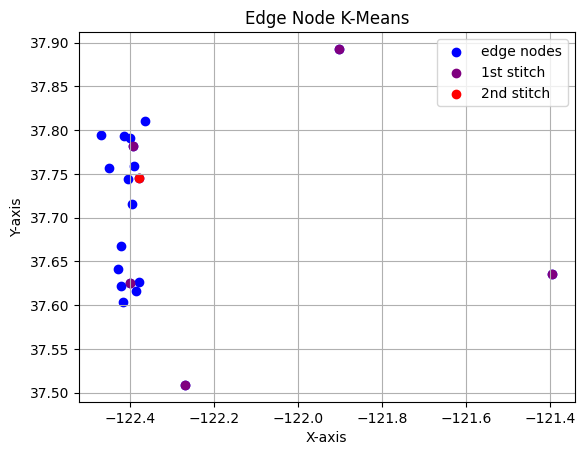

In [240]:
### Results show that we mostly cluster around 2/5 cell tower, due to the other three being geographical outliers

### plot of edge nodes
points = np.array(node_locations_)
first_stitches = points[first_stitch_tree_index_to_node_id]
second_stitches = points[second_stitch_tree_index_to_node_id]
# Plotting the points
plt.scatter(points[:, 0], points[:, 1], color='blue', label='edge nodes')
plt.scatter(first_stitches[:, 0], first_stitches[:, 1], color='purple', label='1st stitch')
plt.scatter(second_stitches[:, 0], second_stitches[:, 1], color='red', label='2nd stitch')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Edge Node K-Means')
plt.grid(True)
plt.legend()
plt.show()

In [269]:
"""
1. From start_time to end_time, add data to links for each car
2. For a time stamp: 
    find a list of all cabs at that time (<= 500 taxis)
    compute first hop (nearest) nodes (20 nodes)
    add data to links for each car: { (x, y) : data }
        consider two links (filter -> 1st aggregate and 1st aggregate –> 2nd aggregate) (1st hop is wireless)
"""

FIRST_HOP_DATA = 10 # car to filter function edge node (1 per car)
SECOND_HOP_DATA = 5 # filter function to first stitch function 
THIRD_HOP_DATA = 5 # first stitch function to second (final) stitch function    

### first hop done through wireless link
edge_node_bandwidth_consumption = [0] * len(node_ids) # bandwidth consumption on wireless link with destination edge node

### assuming complete logical connection between all edge nodes
links_bandwidth_consumption = defaultdict(int)      # { (node_a, node_b) : data }       ## alternatively could be adjacency matrix, but turns out to be a sparse graph
### instead could also append to see consumption over time
# links_bandwidth_consumption = defaultdict(list)      # { (node_a, node_b) : data }       ## alternatively could be adjacency matrix, but turns out to be a sparse graph

def add_data_to_links(position):
    _, closest_node = edge_node_tree.query(np.array([list(position)]))
    filter_node = closest_node[0][0] 
    first_stitch = first_stitch_tree_index_to_node_id[filter_to_first_stitch_node_mapping[filter_node]]
    second_stitch = second_stitch_tree_index_to_node_id[first_stitch_to_second_stitch_node_mapping[first_stitch]]
    # print(filter_node, first_stitch, second_stitch)
    edge_node_bandwidth_consumption[filter_node] += FIRST_HOP_DATA
    links_bandwidth_consumption[(filter_node, first_stitch)] += SECOND_HOP_DATA
    links_bandwidth_consumption[(first_stitch, second_stitch)] += THIRD_HOP_DATA

### execution time: ~10 min for ~23 days of data
for current_time in tqdm(range(min_t, max_t + 1)):
    current_car_positions = time_index[current_time]
    # print(current_car_positions)
    # for each car position, calculate nearest hop using kd-tree: {'adkavy': (-122.42176, 37.76363), 'ackgrica': (-122.43274, 37.73328)}
    for car_id, position in current_car_positions.items():
        add_data_to_links(position)



100%|██████████| 2071531/2071531 [09:10<00:00, 3763.44it/s] 


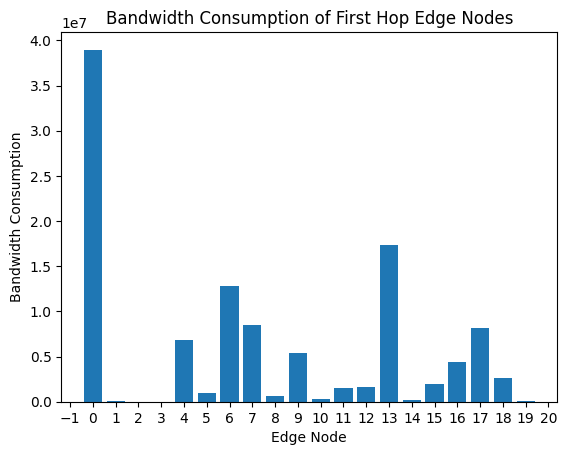

In [332]:
plt.bar(range(len(edge_node_bandwidth_consumption)), edge_node_bandwidth_consumption)
plt.xlabel('Edge Node')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.ylabel('Bandwidth Consumption')
plt.title('Bandwidth Consumption of First Hop Edge Nodes')
plt.show()

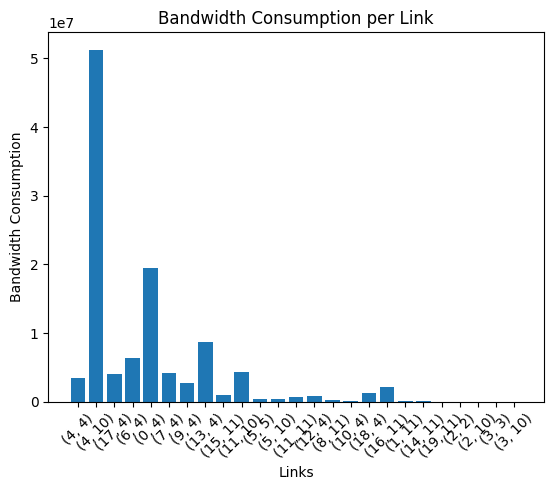

In [323]:
keys = list(map(lambda x: str(x), links_bandwidth_consumption.keys()))
values = links_bandwidth_consumption.values()

plt.bar(keys, values)
plt.xlabel("Links")
plt.xticks(rotation=45)
plt.ylabel("Bandwidth Consumption")
plt.title("Bandwidth Consumption per Link")
plt.show()

In [311]:
# save/restore time_index
# Save the dictionary to a binary file using pickle
with open('link_bw_consumption_0.pkl', 'wb') as pickle_file:
    pickle.dump(links_bandwidth_consumption, pickle_file)

In [ ]:
# links_bandwidth_consumption = None
# # Read the dictionary from the pickle file
# with open('time_index.pkl', 'rb') as pickle_file:
#     links_bandwidth_consumption = pickle.load(pickle_file)

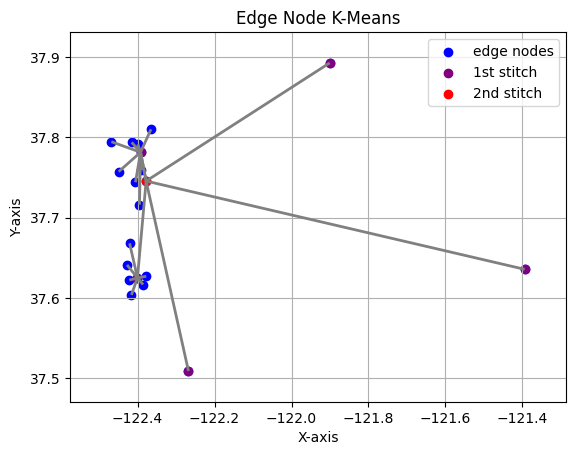

In [334]:
### plot link weights
from matplotlib import collections as mc
from colour import Color

color_a = Color('grey')
color_b = Color('red')

color_range = list(color_a.range_to(color_b, 100))

min_bw = min(links_bandwidth_consumption.values())
max_bw = max(links_bandwidth_consumption.values())

lines = []
c = []

for link, link_bw in links_bandwidth_consumption.items():
    node_a, node_b = link
    pos_a = node_locations_[node_a]
    pos_b = node_locations_[node_b]
    lines.append([pos_a, pos_b])
    idx = ((link_bw - min_bw) / (max_bw - min_bw)) * 99
    color_ = color_range[int(norm)].rgb
    c.append(color_)
    # print(pos_a, pos_b, link_bw)
    

### plot of edge nodes
points = np.array(node_locations_)
first_stitches = points[first_stitch_tree_index_to_node_id]
second_stitches = points[second_stitch_tree_index_to_node_id]

# Plotting the points
lc = mc.LineCollection(lines, colors=c, linewidths=2)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(points[:, 0], points[:, 1], color='blue', label='edge nodes')
plt.scatter(first_stitches[:, 0], first_stitches[:, 1], color='purple', label='1st stitch')
plt.scatter(second_stitches[:, 0], second_stitches[:, 1], color='red', label='2nd stitch')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Edge Node K-Means')
plt.grid(True)
plt.legend()
plt.show()